In [1]:
run_dir = "data/TOPF_run"

"data/TOPF_run"

In [2]:
using TemperateOptimalPowerFlow
using OrderedCollections, DataFrames, ProgressMeter
using Plots, LaTeXStrings

In [3]:
noise_factors = [replace(file, "P_result_" => "", ".h5" => "") for file ∈ readdir(run_dir) if occursin("P_result", file)]
noise_factors = collect(keys(sort(OrderedDict(noise_factors .=> parse.(Float64, noise_factors)), byvalue=true)))

27-element Vector{String}:
 "0"
 "0.1"
 "0.2"
 "0.3"
 "0.5"
 "0.7"
 "1"
 "1.4"
 "2"
 "3"
 "4"
 "5"
 "7"
 ⋮
 "20"
 "30"
 "40"
 "50"
 "70"
 "100"
 "140"
 "200"
 "300"
 "500"
 "700"
 "1000"

# Distribution of line rates

In [4]:
selected_noise_factors = OrderedDict(
    "0"   => "No noise on generation costs",
    "1"   => "Standard noise",
    "10"  => "Moderate noise (x10)",
    "100" => "High noise (x100)"
)
issubset(keys(selected_noise_factors), noise_factors)

true

In [5]:
data = Dict{String, Matrix{Float64}}()
@showprogress for noise ∈ keys(selected_noise_factors)
    data[noise] = retrieve_line_rates(run_dir, "P_result_$noise")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


In [6]:
function log_ticks(exponent_min::Int, exponent_max::Int)
    ticks = reduce(vcat, [10.0^i * collect(1:9) for i = exponent_min:exponent_max])
    labels = [(i % 9 == 0) ? L"10^{%$(round(Int,i/9))}" : "" for i = (9*exponent_min):(9*exponent_max+8)]
    (ticks, labels)
end

log_ticks (generic function with 1 method)

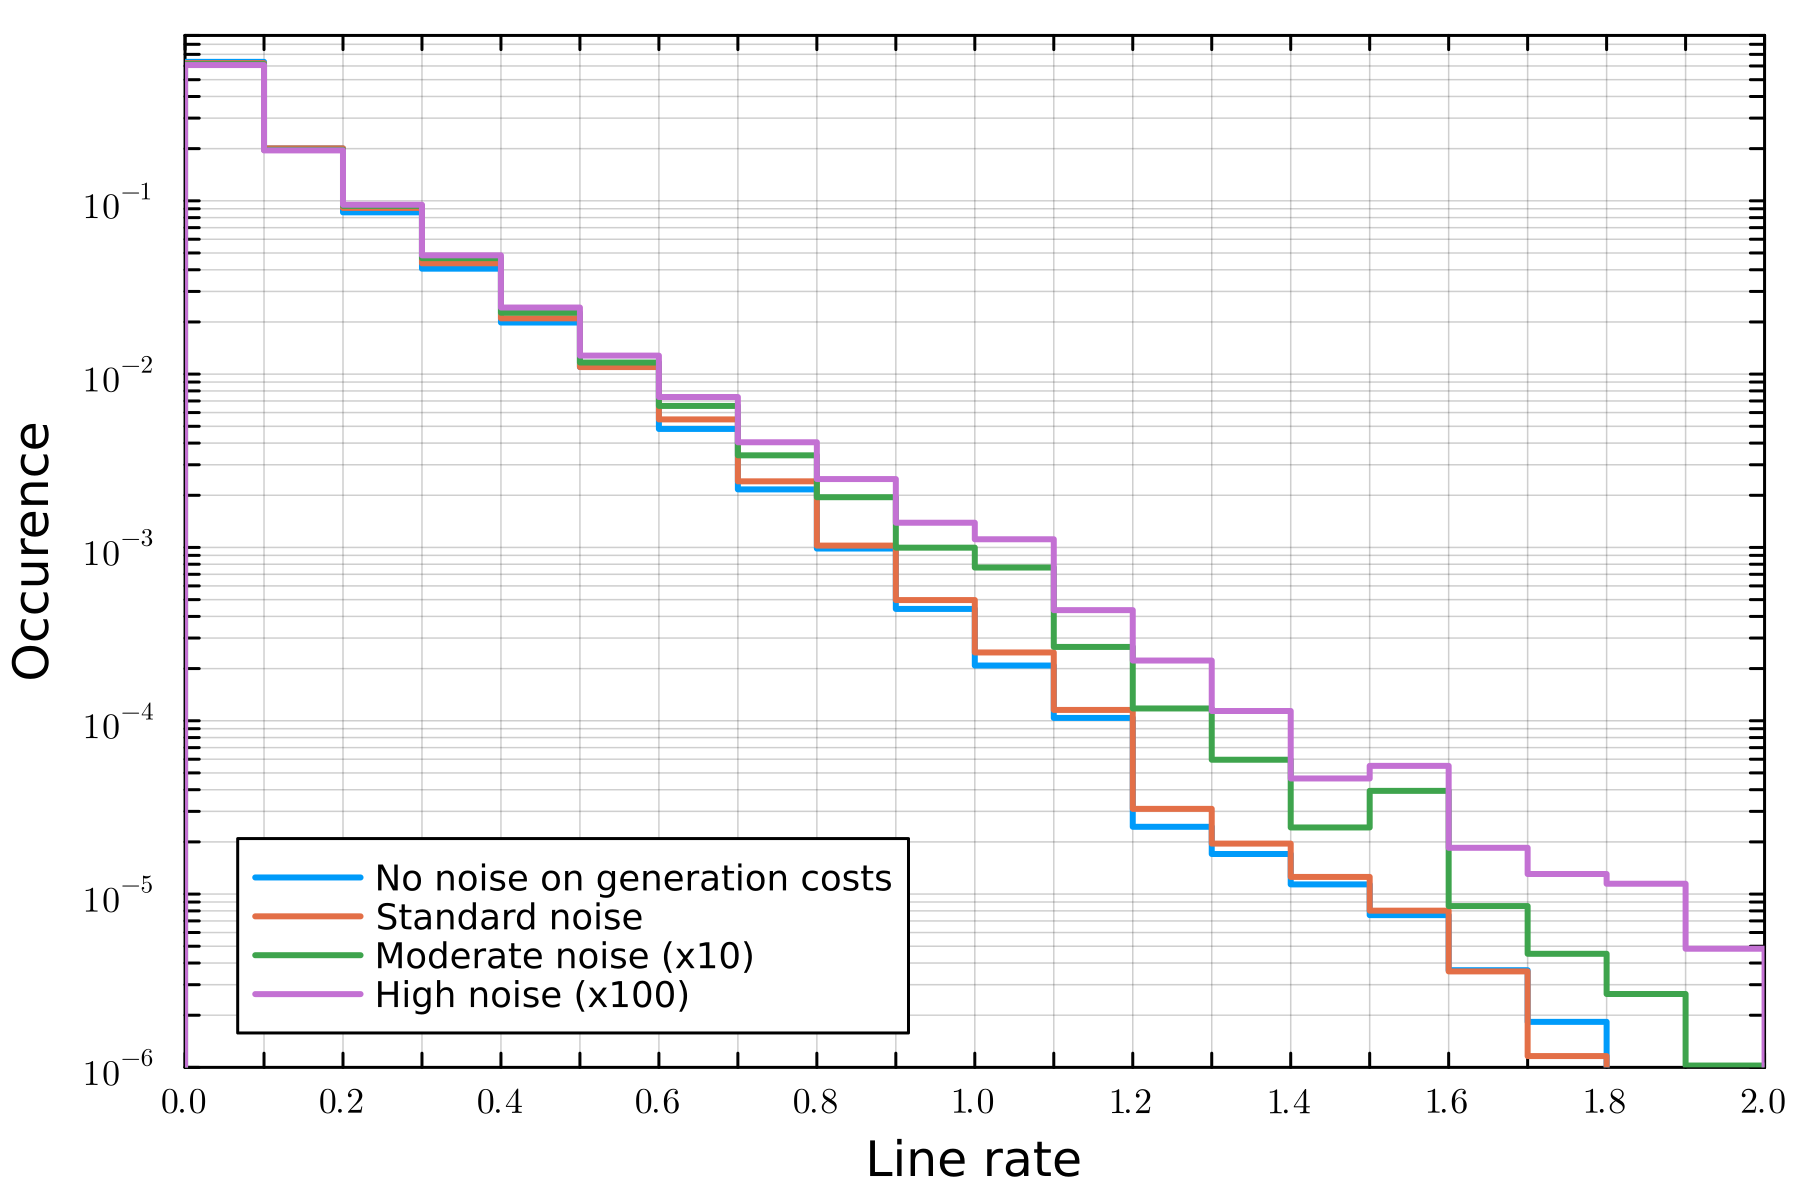

In [7]:
plot(framestyle = :box, dpi=300, legend=:bottomleft, xlabel="Line rate", ylabel="Occurence",
    xlims=(0,2), x_ticks = ([x/10 for x = 0:20], [(x % 2 == 0) ? latexstring(x / 10) : "" for x = 0:20]),
    ylims=(1e-6, 0.9), y_ticks = log_ticks(-6, -1))
for (noise, label) in selected_noise_factors
    stephist!(reshape(data[noise], (length(data[noise]))), label = label, normalize=:probability,
        bins=range(0, 2, length=21), linewidth=2, yscale=:log10)
end
savefig("figures/line_rate_distribution.pdf")
plot!()

### Without the most problematic lines

In [8]:
problematic_lines = [3227, 3310, 5585, 6132]

data_reduced = Dict(noise => table[[i for i = 1:size(table, 1) if i ∉ problematic_lines], :] for (noise, table) ∈ data)

Dict{String, Matrix{Float64}} with 4 entries:
  "1"   => [0.0555183 0.0553844 … 0.0514645 0.0549159; 0.0555183 0.0553844 … 0.…
  "10"  => [0.0555183 0.0553844 … 0.0514645 0.0549159; 0.0555183 0.0553844 … 0.…
  "0"   => [0.018925 0.0186583 … 0.0433476 0.0397089; 0.018925 0.0186583 … 0.04…
  "100" => [0.0555183 0.0553844 … 0.0514645 0.0549159; 0.0555183 0.0553844 … 0.…

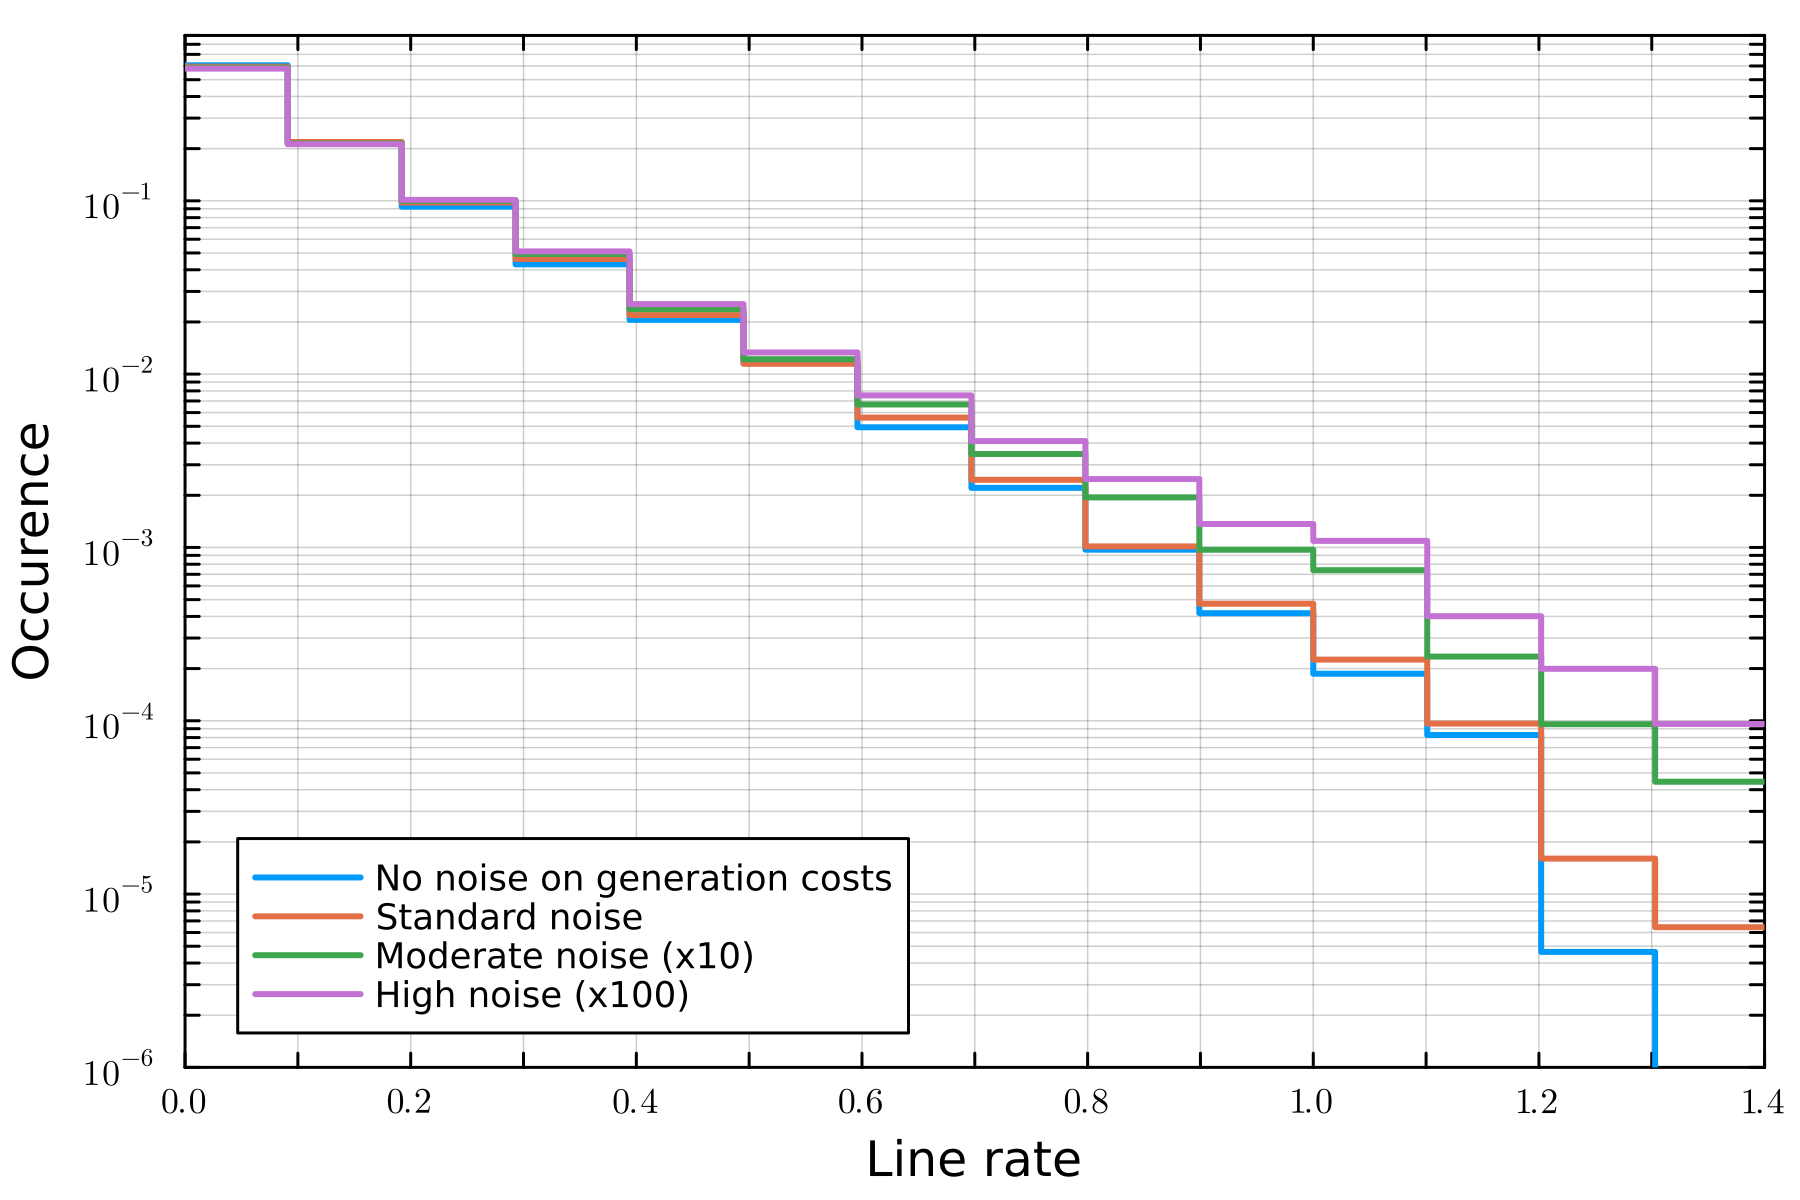

In [9]:
plot(framestyle = :box, dpi=300, legend=:bottomleft, xlabel="Line rate", ylabel="Occurence",
    xlims=(0, 1.4), x_ticks = ([x/10 for x = 0:14], [(x % 2 == 0) ? latexstring(x / 10) : "" for x = 0:14]),
    ylims=(1e-6, 0.9), y_ticks = log_ticks(-6, -1))
for (noise, label) in selected_noise_factors
    stephist!(reshape(data_reduced[noise], (length(data_reduced[noise]))), label = label, normalize=:probability,
        bins=range(-0.01, 2.01, length=21), linewidth=2, yscale=:log10)
end
plot!()

# Counting lines above threshold

In [10]:
thresholds = Dict(
    "above80"  => 0.8,
    "above100" => 1.0,
    "above120" => 1.2
    )

Dict{String, Float64} with 3 entries:
  "above100" => 1.0
  "above120" => 1.2
  "above80"  => 0.8

In [11]:
line_rate_thresholds = DataFrame(noise = Vector{Float64}())
for threshold ∈ keys(thresholds)
    line_rate_thresholds[!, threshold] = Vector{Float64}()
end
@showprogress for noise in noise_factors
    table = retrieve_line_rates(run_dir, "P_result_$noise")
    df = DataFrame(Dict(key => sum(table .> threshold) / length(table) for (key, threshold) ∈ thresholds))
    df[!, "noise"] = [parse(Float64, noise)]
    append!(line_rate_thresholds, df)
end
line_rate_thresholds

Progress: 100%|█████████████████████████████████████████| Time: 0:03:49


Row,noise,above100,above120,above80
,Float64,Float64,Float64,Float64
1,0.0,0.000378301,6.62348e-5,0.00180574
2,0.1,0.000378547,6.5155e-5,0.00180279
3,0.2,0.000379818,6.33235e-5,0.00180116
4,0.3,0.000382675,6.1615e-5,0.00180764
5,0.5,0.000396602,6.17243e-5,0.00183075
6,0.7,0.000413742,6.65628e-5,0.00187162
7,1.0,0.000439314,7.6144e-5,0.00196079
8,1.4,0.000477475,9.0796e-5,0.00214182
9,2.0,0.00055254,0.000111284,0.00245993


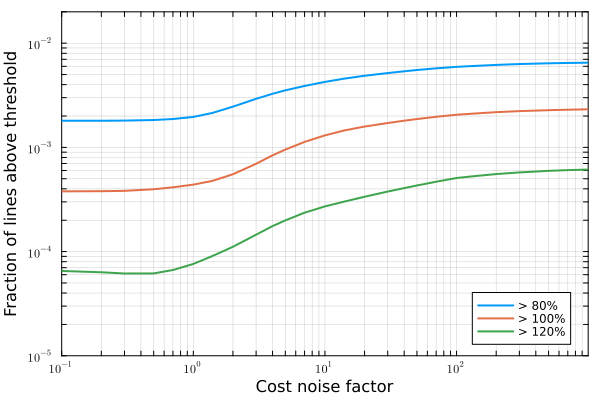

In [12]:
plot(line_rate_thresholds.noise[2:end], line_rate_thresholds.above80[2:end], label = "> 80%", linewidth=2, framestyle=:box,
    xlims=(0.1, 1000), x_ticks = log_ticks(-1, 2), xscale=:log10,
    ylims=(1e-5, 2e-2), y_ticks = log_ticks(-5, -2), yscale=:log10,
    xlabel="Cost noise factor", ylabel="Fraction of lines above threshold",
    legend=:bottomright)
plot!(line_rate_thresholds.noise[2:end], line_rate_thresholds.above100[2:end], label = "> 100%", linewidth=2)
plot!(line_rate_thresholds.noise[2:end], line_rate_thresholds.above120[2:end], label = "> 120%", linewidth=2)
savefig("figures/line_rate_thresholds.pdf")
plot!()